# Triplet networks & one-shot learning

Train a triplet network on the first 80 classes of (the training set of) Cifar-100


In [0]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization, merge, concatenate, Activation, Concatenate
from keras.models import Model, Sequential
from keras.layers import LeakyReLU
from keras.regularizers import l2
from keras import backend as K
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar100
from keras.losses import binary_crossentropy
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal, RandomNormal

import numpy as np
import os
import pickle
from itertools import permutations
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [0]:

input_size = (32, 32, 3)
# embedding_dimensions = 128
batch_size = 256
num_classes = 100
num_train_classes = 80
num_test_classes = num_classes - num_train_classes

(cifar_x_train, cifar_y_train), (cifar_x_test, cifar_y_test) = cifar100.load_data(label_mode='fine')

# reshape output labels
cifar_y_train = cifar_y_train.reshape(-1)
cifar_y_test = cifar_y_test.reshape(-1)

In [25]:
print(cifar_x_train.shape)
print(cifar_y_train.shape)
print(cifar_x_test.shape)
print(cifar_y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [0]:
sorted_indices = np.argsort(cifar_y_train)
cifar_x_train = cifar_x_train[sorted_indices]
cifar_y_train = cifar_y_train[sorted_indices]
split_index = np.searchsorted(cifar_y_train, num_train_classes)

In [27]:
x_train = cifar_x_train[:split_index]
y_train = cifar_y_train[:split_index]

# take the last 20 classes as test
x_validation = cifar_x_train[split_index:]
y_validation = cifar_y_train[split_index:]

# NOTE: assumption that the number of samples
#       are divisible by the number of classes
x_train = x_train.reshape(num_train_classes, x_train.shape[0]//num_train_classes, *x_train.shape[1:])
x_validation = x_validation.reshape(num_test_classes, x_validation.shape[0]//num_test_classes, *x_validation.shape[1:])

print(x_train.shape)
print(y_train.shape)

(80, 500, 32, 32, 3)
(40000,)


In [0]:
def get_batch(batch_size, X):
    """Create batch of n triplets anchor, positive, negative"""
    n_classes, n_examples, w, h, d = X.shape
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    # initialize 3 empty arrays for the input image batch
    triplet = [np.zeros((batch_size, h, w, 3)) for i in range(3)]
    # initialize dummy vector fot labels (useless in triplenet)
    targets = np.zeros((batch_size,))

    for i in range(batch_size):
      category = categories[i]
      idx_1, idx_2 = random.sample(range(n_examples),k=2)
      triplet[0][i, :, :, :] = X[category, idx_1].reshape(w, h, 3)
      triplet[1][i, :, :, :] = X[category, idx_2].reshape(w, h, 3)
      idx_3 = np.random.randint(0, n_examples)
      category_2 = (category + np.random.randint(1,n_classes)) % n_classes
      triplet[2][i, :, :, :] = X[category_2,idx_3].reshape(w, h, 3)
    return triplet, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
      triplet, targets = get_batch(batch_size, X)
      yield (triplet, targets)

def train(model, X_train, batch_size=64, steps_per_epoch=250, epochs=1):
    model.fit_generator(batch_generator(batch_size, X_train), 
                        steps_per_epoch=steps_per_epoch, epochs=epochs)

(3, 2, 32, 32, 3)


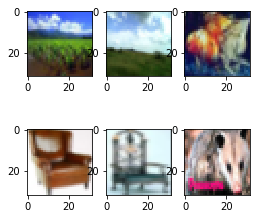

In [34]:
#test: the first 2 images should be in the same class
for b in batch_generator(2,x_train):
  a = np.array(b[0], np.uint8)
  print(a.shape)
  image1 = a[0][0]
  image2 = a[1][0]
  image3 = a[2][0]
  image4 = a[0][1]
  image5 = a[1][1]
  image6 = a[2][1]
  fig=plt.figure(figsize=(4, 4))
  for i in range(1,7):
    fig.add_subplot(2, 3, i)
    if i==1:
      plt.imshow(image1)
    elif i==2:
      plt.imshow(image2)
    elif i==3:
      plt.imshow(image3)
    elif i==4:
      plt.imshow(image4)
    elif i==5:
      plt.imshow(image5)
    elif i==6:
      plt.imshow(image6)      
  plt.show()
  break

In [0]:
import tensorflow as tf
def triplet_loss(ground_truth, network_output):
    anchor, positive, negative = tf.split(network_output, num_or_size_splits=3, axis=1)
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = K.mean(pos_dist-neg_dist+0.5)
    loss = K.maximum(basic_loss,0.0)
    return loss


In [0]:
input_shape = (32, 32, 3)
anchor_input = Input(input_shape, name='anchor')
positive_input = Input(input_shape, name='positive')
negative_input = Input(input_shape, name='negative')

# build convnet to use in each siamese 'leg'
conv_input = Input(input_shape)
tripleNet = Sequential()

tripleNet.add(Conv2D(64, (3,3), input_shape=input_shape, padding='SAME'))
tripleNet.add(BatchNormalization())
tripleNet.add(LeakyReLU(alpha=0.1))
tripleNet.add(MaxPooling2D())
tripleNet.add(Dropout(0.3))

tripleNet.add(Conv2D(128, (3,3), input_shape=input_shape, padding='SAME'))
tripleNet.add(BatchNormalization())
tripleNet.add(LeakyReLU(alpha=0.1))
tripleNet.add(MaxPooling2D())
tripleNet.add(Dropout(0.3))

tripleNet.add(Conv2D(256, (3,3), input_shape=input_shape, padding='SAME'))
tripleNet.add(BatchNormalization())
tripleNet.add(LeakyReLU(alpha=0.1))
tripleNet.add(MaxPooling2D())
tripleNet.add(Dropout(0.3))

tripleNet.add(Flatten())

tripleNet.add(Dense(1024, kernel_regularizer=l2(1e-3)))
tripleNet.add(Dense(128, kernel_regularizer=l2(1e-3)))
tripleNet.add(Lambda(lambda t: K.l2_normalize(t, axis=1)))

anchor_tp_leg = tripleNet(anchor_input)
positive_tp_leg = tripleNet(positive_input)
negative_tp_leg = tripleNet(negative_input)

In [37]:
concat = Concatenate(axis=-1, name='concatenate')([anchor_tp_leg,
                                                   positive_tp_leg,
                                                   negative_tp_leg])

triplet_net = Model(inputs=[anchor_input, positive_input,
                            negative_input], outputs=concat)
triplet_net.compile(loss=triplet_loss,
                    optimizer=Adam(lr=0.0001, amsgrad=True, decay=0.0000001))

triplet_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
negative (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          4699136     anchor[0][0]                     
                                                                 positive[0][0]                   
          

In [0]:
def triplet_make_oneshot_task(N, X, start_id=80):
  """
    Generate a test image and its corresponding support set.
    It returns the image, its ground truth label, the support set
    and the associated labels for each support set image.
    
    start_class_id parameter is necessary in case the classes from X set
    do not start from id 0. (Eg. Cifar100 tested on last 20 classes).
  """
  n_classes, n_examples, w, h, chn = X.shape
  categories = np.random.choice(n_classes, N, replace=False)
  # take N+1 so that two indices can be used to draw from same category
  samples_ids = np.random.choice(n_examples, N+1, replace=False)

  true_category = categories[0]+start_id
  
  # the reshape is necessary to later stack this img with the support set
  test_image = X[categories[0], samples_ids[0]].reshape(1, w, h, chn)
  support_set = np.asarray([X[categories[i], samples_ids[i+1]] for i in range(N)])
  
  support_categories = np.asarray([categories[i]+start_id for i in range(N)])
  
  # shuffle the support set
  random_indices = np.random.choice(len(support_set),
                                    len(support_set), replace=False)
  support_set = support_set[random_indices]
  support_categories = support_categories[random_indices]

  return test_image, true_category, support_set, support_categories

# L2-distance (MSE - Mean Square Error)
def mean_square_error(a, b):
  return ((a - b)**2).mean(axis=None)

def triplet_test_oneshot(model, X, N=20, K=250, verbose=True):
  """
    Test average N-way oneshot learning accuracy
    using the neural codes obtained by a pretrained triplet net
    and L2 distance over k one-shot tasks.
  """
  n_correct = 0
  if verbose:
      print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(K, N))
      
  for i in range(K):
      test_img, true_label, support_set, support_labels = triplet_make_oneshot_task(N, X)
      
      test_img_nn = model.predict(test_img)
      
      ss_neural_codes = model.predict(support_set, batch_size=support_set.shape[0])
      
      errors = [mean_square_error(test_img_nn, ss_nn)
                for ss_nn in ss_neural_codes]
      
      # check whether the closes image is actually
      # of the same class of the test image
      # NOTE -> argmin is the index, not the correct class!!!!!!!!!!!!
      if true_label == support_labels[np.argmin(errors)]:
          n_correct += 1
          
  # compute the accuracy
  percent_correct = (100.0 * n_correct / K)
  
  if verbose:
      print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
      
  return percent_correct

In [40]:
loops = 100
best_acc = 0
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    train(triplet_net, x_train)
    triplet_neural_codes = Model(inputs=anchor_input, outputs=anchor_tp_leg)

    test_acc = triplet_test_oneshot(triplet_neural_codes, x_validation, K=250)
    if test_acc >= best_acc:
        print("********* New best one-shot accuracy, saving model ********")
        triplet_neural_codes.save(os.path.join(".", "triplet_neural_codes.h5"))
        best_acc = test_acc

=== Training loop 1 ===
Epoch 1/1
250/250 [==============================] - 10s 39ms/step - loss: 1.4828
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.6% accuracy for 20-way one-shot learning
********* New best one-shot accuracy, saving model ********
=== Training loop 2 ===
Epoch 1/1
250/250 [==============================] - 9s 38ms/step - loss: 1.1735
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 10.0% accuracy for 20-way one-shot learning
********* New best one-shot accuracy, saving model ********
=== Training loop 3 ===
Epoch 1/1
250/250 [==============================] - 10s 38ms/step - loss: 0.9017
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
********* New best one-shot accuracy, saving model ********
=== Training loop 4 ===
Epoch 1/1
250/250 [==============================] - 10s 38ms/step - loss: 0.6745
Evaluating mod

In [41]:
print(best_acc)

21.2
